<a href="https://colab.research.google.com/github/samindelhi/CNN-Exercises/blob/main/Xception_Transfer_Learning_WithCorrection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xception Transfer Learning - Image Classification. with Correction.
This notebook demonstrates how to use Xception with transfer learning on a small custom dataset


In [1]:
# Import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import gdown



# Dataset Link: https://drive.google.com/file/d/1TCU1nqgIe1R_dW6LTkRxlufHlCCazyJl/view?usp=sharing

In [2]:
# google drive file id
file_id = "1TCU1nqgIe1R_dW6LTkRxlufHlCCazyJl"
# Download destination filename
output = "myfile.zip"

# download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)



Downloading...
From (original): https://drive.google.com/uc?id=1TCU1nqgIe1R_dW6LTkRxlufHlCCazyJl
From (redirected): https://drive.google.com/uc?id=1TCU1nqgIe1R_dW6LTkRxlufHlCCazyJl&confirm=t&uuid=d43ad8e3-1ede-48cb-9b12-34fedc6833f3
To: /content/myfile.zip
100%|██████████| 63.9M/63.9M [00:00<00:00, 91.9MB/s]


'myfile.zip'

In [3]:
import zipfile
with zipfile.ZipFile("myfile.zip", 'r') as zip_ref:
  zip_ref.extractall("dataset")


In [4]:
# Define paths
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/valid"
img_size= 299
batch_size = 32

In [5]:
# Data Generators thru augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.xception.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range = 0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical'
)




Found 1275 images belonging to 2 classes.
Found 364 images belonging to 2 classes.


In [6]:
# Load base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size,3))
base_model.trainable=False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [8]:
# Add custom classifier
x = base_model.output
x= GlobalAveragePooling2D()(x)
x= Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



In [9]:
# compile the model.
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
# Train the model (initial training with frozen base.)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data = val_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.5599 - loss: 0.6998 - val_accuracy: 0.8654 - val_loss: 0.5272
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 961ms/step - accuracy: 0.7785 - loss: 0.5339 - val_accuracy: 0.9203 - val_loss: 0.4101
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 906ms/step - accuracy: 0.8442 - loss: 0.4479 - val_accuracy: 0.9231 - val_loss: 0.3393
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 919ms/step - accuracy: 0.8889 - loss: 0.3717 - val_accuracy: 0.9231 - val_loss: 0.2970
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 909ms/step - accuracy: 0.8848 - loss: 0.3414 - val_accuracy: 0.9231 - val_loss: 0.2679
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 914ms/step - accuracy: 0.9003 - loss: 0.3002 - val_accuracy: 0.9313 - val_loss: 0.2473
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 911ms/step - accuracy: 0.9028 - loss: 0.2785 - val_accuracy: 0.9286 - val_loss: 0.2316
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 913ms/step - accuracy: 0.9142 - loss: 0.2577 - val_accura

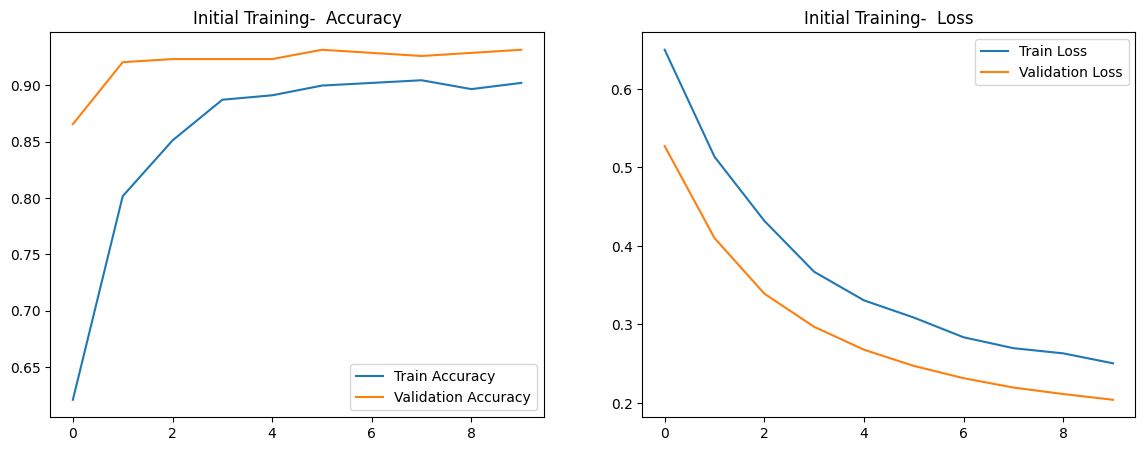

In [12]:
# plot training history
def plot_history(history, title):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(14,5))

  plt.subplot(1,2,1)
  plt.plot(epochs, acc, label='Train Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title(f"{title}-  Accuracy")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, label='Train Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title(f"{title}-  Loss")
  plt.legend()

  plt.show()

plot_history(history, "Initial Training")



In [13]:
# Save the model.

model.save ("Xception_transfer_learning_model.h5")
model.save ("Xception_transfer_learning_model.keras")

In [14]:
from tensorflow.keras.models import load_model
model = load_model("Xception_transfer_learning_model.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_image(model, image_path):
  img = load_img(image_path, target_size = (299,299))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = tf.keras.applications.xception.preprocess_input(img_array)

  predictions = model.predict(img_array)
  predicted_class=  np.argmax(predictions, axis=1)
  class_indices = {v:k for k,v in train_generator.class_indices.items()}
  return class_indices[predicted_class[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Label: daisy


Text(0.5, 1.0, 'daisy')

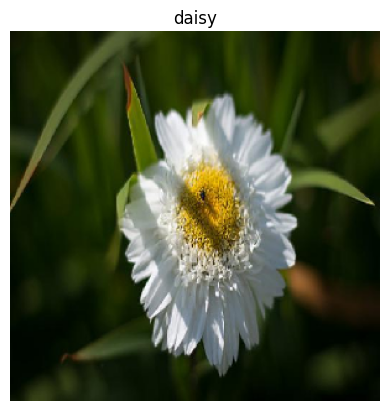

In [29]:
# Example usage
image_path = "/content/dataset/test/daisy/14613443462_d4ed356201_jpg.rf.76462b3f0cb5ca5a0b4b7c9894feb91c.jpg"  # Update path accordingly
predicted_label = predict_image(model, image_path)
print("Predicted Label:", predicted_label)

plt.imshow(load_img(image_path,target_size=(299,299)))
plt.axis('off')
plt.title(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Label: dandelion


Text(0.5, 1.0, 'dandelion')

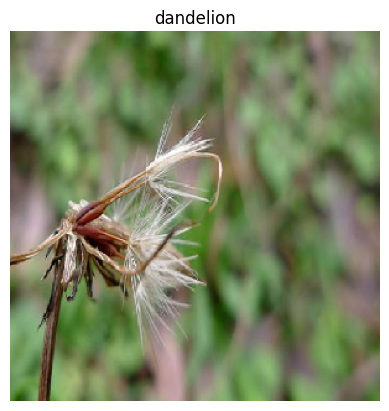

In [31]:
# Example usage
image_path = "/content/dataset/test/dandelion/13887031789_97437f246b_jpg.rf.bb669fcee9abb45aabf5352790b35ec8.jpg"  # Update path accordingly
predicted_label = predict_image(model, image_path)
print("Predicted Label:", predicted_label)

plt.imshow(load_img(image_path,target_size=(299,299)))
plt.axis('off')
plt.title(predicted_label)